In [1]:
import numpy as np
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

# Diving Deep Into ROC Curves; Review

I am going to go back to the spam/ham dataset from Monday so that we can get a better understanding of ROC curves.

However, most of the code is from Wednesday.

## I. Load and Look at our data

Let's load and __look at our data__. 

In [2]:
data = np.array(np.genfromtxt('data/SMSSpamCollection', delimiter='\t', encoding='utf-8', dtype=str))  
print(data.shape)

(5574, 2)


## II. Split the data

Let's split the data into train, dev and test. 

When we check by printing shapes and unique values, does everything look okay?

In [3]:
train_data, dev_data, test_data = np.split(data, [int(.8 * len(data)), int(.9 * len(data))])
print(train_data.shape, dev_data.shape, test_data.shape)
print(np.unique(train_data[:, 0]), np.unique(dev_data[:, 0]), np.unique(test_data[:, 0]))

(4459, 2) (557, 2) (558, 2)
['ham' 'spam'] ['ham' 'spam'] ['ham' 'spam']


## III. Preprocess the data

On Monday we tokenized the data and extracted counts for each token for each class ourselves.

Today I'm going to use two scikit-learn utilities:
* CountVectorizer - will tokenize and count
* LabelEncoder - will map the string labels to ints

As on Monday, I use *only the training data* to extract my token vocabulary.

In [5]:
vectorizer = CountVectorizer(lowercase=True, analyzer='word', max_features=1000)

vectorizer.fit(iter(train_data[:, 1]))
# We have to use np.asarray because sklearn 1.0 doesn't want matrices for naive Bayes
train_processed = np.asarray(vectorizer.transform(iter(train_data[:, 1])).todense())
dev_processed = np.asarray(vectorizer.transform(iter(dev_data[:, 1])).todense())
test_processed = np.asarray(vectorizer.transform(iter(test_data[:, 1])).todense())

encoder = LabelEncoder()
encoder.fit(train_data[:, 0])
train_labels = encoder.transform(train_data[:, 0])
dev_labels = encoder.transform(dev_data[:, 0])
test_labels = encoder.transform(test_data[:, 0])

## IV. Fit, Predict and Score

Today I'm going to compare the performance of several scikit-learn Naive Bayes alternatives on this dataset. If you recall from last week, these variations on Naive Bayes model different *probability distributions* over the training data, rather than using the likelihoods and priors directly.

Although we aren't using our own, hand-written Naive Bayes, you can see that the pattern is the same:
1. Fit
2. Predict
3. Score

With respect to "score", you'll see we are calculating:
* precision
* recall
* F1

*per class*. 

Here is a review from Monday:

Let's make a different version of the confusion matrix focusing on just the 'spam' class, which is the class we really want to do well on:

| | Predict not in 'spam' | Predict in 'spam' | Rates |
| -- | --- | --- | -- |
| Actual not in 'spam' | TN | FP | FPR = FP/(FP+TN) |
| Actual in 'spam' | FN | TP | TPR = TP/(TP+FN) |

With a table like this, we can calculate:
* Precision (how many of those we guessed were 'spam' were actually 'spam'?): TP / (TP + FP)
* Recall (how many actual 'spam' did we guess were 'spam'?): TP / (TP + FN)

Then, to get an assessment of recall and precision together, we can calculate F1: (2\*Precision\*Recall)/(Precision+Recall)

We can also plot the ROC curve and calculate AUC.
* ROC - receiver operating characteristic curve, constructed by plotting the TPR against the FPR
* AUC - area under the ROC curve


Today, we depict the confusion matrix using a heatmap, for variety.

Also, because this is binary classification we will plot the ROC curve and calculate AUC.

Q: What is a situation in which you might prefer to know P/R/F1 instead of accuracy, or where accuracy might be misleading?

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       484
        spam       0.90      0.95      0.92        73

    accuracy                           0.98       557
   macro avg       0.94      0.96      0.95       557
weighted avg       0.98      0.98      0.98       557

[[476   8]
 [  4  69]]


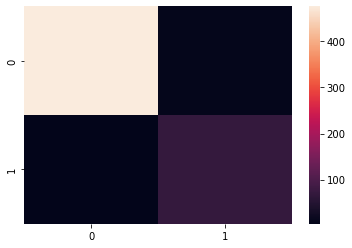

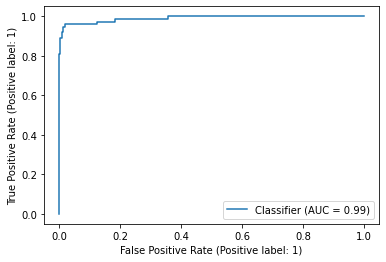

In [7]:
nb = MultinomialNB()
nb.fit(train_processed, train_labels)
pred = nb.predict(dev_processed)
print(classification_report(dev_labels, pred, target_names=encoder.classes_))
print(confusion_matrix(dev_labels, pred))
sns.heatmap(confusion_matrix(dev_labels, pred))
RocCurveDisplay.from_predictions(dev_labels, nb.predict_proba(dev_processed)[:, 1])

Let's take a closer look at those predictions. We will call predict_proba instead of predict. This will give us the *probabilities* the naive Bayes classifier uses to determine the best class. So for each data point, we will have the probability of ham and the probability of spam. 

Q: Are these the prior, likelihood, normalization or posterior probabilities?

In [8]:
pred_with_probs = nb.predict_proba(dev_processed)
print(pred_with_probs)

[[9.99064095e-01 9.35905033e-04]
 [9.29788037e-11 1.00000000e+00]
 [1.00000000e+00 8.04493964e-14]
 ...
 [9.98579626e-01 1.42037438e-03]
 [9.87359478e-01 1.26405222e-02]
 [9.99999974e-01 2.63143889e-08]]


By default, we take the label with the maximum probability, right? However, you can see that one way we could "adjust" the classifier is to set a threshold for making a decision; so for example, it's not spam unless the probability of spam is at least 60%.

Q: What would be the effect of setting that 60% threshold?

The ROC curve plots the FPR (x axis) against the TPR (y axis). 

Q: What do FPR and TPR stand for, again?

So the ROC curve illustrates the thresholds that are available to us, and the consequences if we choose a different threshold.

Now, AUC is the area under that curve.

Q: If AUC is 1, then what can we say about the model?

Q: If AUC is 0, then what can we say about the model?

Quite often, you will see a ROC curve plotted against a diagonal line as in ![this example from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/d/de/ROC_curve.svg)

Q: What does the diagonal line denote?

              precision    recall  f1-score   support

         ham       0.98      0.79      0.88       484
        spam       0.40      0.92      0.55        73

    accuracy                           0.81       557
   macro avg       0.69      0.85      0.71       557
weighted avg       0.91      0.81      0.83       557



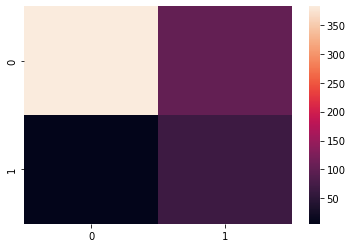

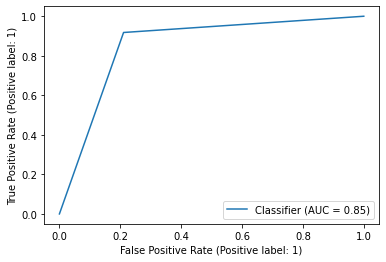

In [9]:
nb = GaussianNB()
nb.fit(train_processed, train_labels)
pred = nb.predict(dev_processed)
print(classification_report(dev_labels, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(dev_labels, pred))
RocCurveDisplay.from_predictions(dev_labels, nb.predict_proba(dev_processed)[:, 1])

              precision    recall  f1-score   support

         ham       0.99      0.96      0.98       484
        spam       0.79      0.96      0.86        73

    accuracy                           0.96       557
   macro avg       0.89      0.96      0.92       557
weighted avg       0.97      0.96      0.96       557



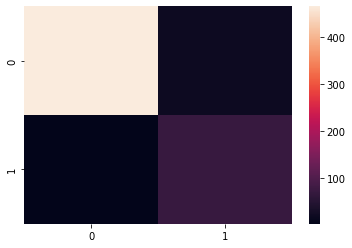

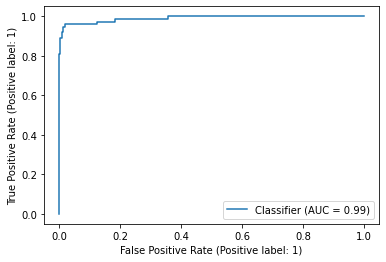

In [10]:
nb = ComplementNB()
nb.fit(train_processed, train_labels)
pred = nb.predict(dev_processed)
print(classification_report(dev_labels, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(dev_labels, pred))
RocCurveDisplay.from_predictions(dev_labels, nb.predict_proba(dev_processed)[:, 1])

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       484
        spam       0.98      0.89      0.94        73

    accuracy                           0.98       557
   macro avg       0.98      0.94      0.96       557
weighted avg       0.98      0.98      0.98       557



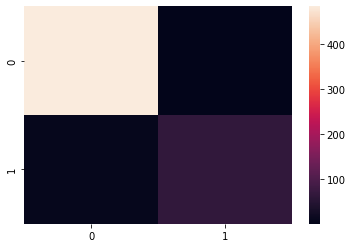

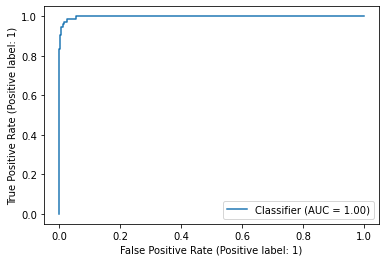

In [11]:
nb = BernoulliNB()
nb.fit(train_processed, train_labels)
pred = nb.predict(dev_processed)
print(classification_report(dev_labels, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(dev_labels, pred))
RocCurveDisplay.from_predictions(dev_labels, nb.predict_proba(dev_processed)[:, 1])

Q. Looking at these ROC curves and AUC scores, which model would you choose? Why? Does your choice correspond to the model with highest accuracy? 

You *can* plot ROC curves for multiclass classifiers, but you have to do it one label at a time, either:
* one versus rest - assume this class is "positive" and all the other datapoints are "negative"
* one versus one - compare pairs of labels

## V. Resources

* https://towardsdatascience.com/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time-fb2304c83a7f
* https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077
* https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a